<div class="alert alert-block alert-info">
<b> Use bag-of-words to impute industry sector</b> 
</div>

In [1]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
import string
import csv

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
from sklearn import metrics

%matplotlib inline

sns.set_style("darkgrid")

In [2]:
# reading cleaned data from EDA portion
df = pd.read_pickle("./loancleaned.pkl")

In [3]:
# there are a hefty amount of null entries in the sector
df.sector.isnull().sum()

5967

In [4]:
df[df.sector.isnull()].Name.sample(10)

ID
8726343002    KILARNEY RESTAURANT MNGMT INC
9823343009             FABER BURNER COMPANY
6224993010          CAR CARE AUTO PARTS INC
3550283000                         ART MART
5668163004                    LILLIE DA VID
8004463001                   SAN'S PIZZERIA
6134573009                      EATON FARMS
9420733003           CORINTHIAN HAIR STUDIO
3681464002                 TRIPLE FRESH INC
4512243003       MOIO'S ITALIAN PASTRY SHOP
Name: Name, dtype: object

<div class="alert alert-block alert-info">
given the business name, it may be possible to assign an industry using most frequently 
occurring word vectors of businesses in various sectors. </div>

In [5]:
nltk.corpus.names.words()[:5]

['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']

In [6]:
sw = stopwords.words('english')
# dba = doing business as cropped up quite a lot in ALL industries.
newwords = ['llc', 'inc', 'ltd', 'corp', 'co', 'company', 'bros', 'son','sons', 'associates', 
           'corporation', 'enterprises', 'center', 'group', 'family', 'dba']
for n in newwords:
    sw.append(n)
for n in nltk.corpus.names.words():
    # add 's' to end of name as most businesses will use names in possessive context
    sw.append(n.lower()+'s')
    sw.append(n.lower())

In [7]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = ''.join(ch for ch in mess if ch not in string.punctuation)

    # remove digits
    nopunc = ''.join([char for char in mess if not char.isdigit()])
    
    # Now just remove any stopwords
    text =  [word.lower() for word in nopunc.split() if word.lower() not in sw]
    text = " ".join(str(t) for t in text)
    return text

In [8]:
df['name2'] = df.Name.apply(lambda x: text_process(x))

In [3]:
df.to_pickle('./wtext2.pkl')
#df = pd.read_pickle("./wtext2.pkl")

### Preparing for Modelling

In [10]:
Xtrain = df[~df.sector.isnull()].name2
Xtest = df[df.sector.isnull()].name2
ytrain = df[~df.sector.isnull()].sector

In [11]:
print(Xtrain.shape)
print(Xtest.shape)

(27880,)
(5967,)


In [12]:
Xtest.head()

ID
1001725002        faust funeral home
1001785009    reading used furniture
1001885004                    h plus
1001905008                    h plus
1001915000                    h plus
Name: name2, dtype: object

In [13]:
# Let's use the CountVectorizer to count words for us.
cvt      =  CountVectorizer(ngram_range=(1,1), lowercase=False, max_features=5000)
XtrainT    =  cvt.fit_transform(Xtrain)
XtestT = cvt.transform(Xtest)

In [14]:
XtrainT.astype(np.int8)

<27880x5000 sparse matrix of type '<class 'numpy.int8'>'
	with 48120 stored elements in Compressed Sparse Row format>

In [15]:
XtrainT = pd.DataFrame(XtrainT.todense(), columns=cvt.get_feature_names())
XtrainT.shape

(27880, 5000)

In [16]:
XtestT = pd.DataFrame(XtestT.todense(), columns=cvt.get_feature_names())
XtestT.shape

(5967, 5000)

### Modelling

<div class="alert alert-block alert-info">
<b>1. K-Nearest Neighbours</b> 
</div>

In [17]:
#let's first try KNN
from sklearn.neighbors import KNeighborsClassifier

# 2. instantiate the model (with the default parameters)
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# 3. fit the model with data (occurs in-place)
knn.fit(XtrainT, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [18]:
ypred = knn.predict(XtestT)

In [19]:
ypred[:10]

array(['81', '44', '44', '44', '44', '31', '31', '31', '44', '54'],
      dtype=object)

In [20]:
%store ypred

Stored 'ypred' (ndarray)


<div class="alert alert-block alert-info">
<b>2. Multinomial Naive Bayes</b> 
</div>

In [21]:
sectormodel = MultinomialNB().fit(XtrainT,ytrain)

In [22]:
ypred2 = sectormodel.predict(XtestT)

In [23]:
ypred2[:10]

array(['81', '44', '44', '44', '44', '44', '31', '31', '44', '54'],
      dtype='<U2')

In [24]:
%store ypred2

Stored 'ypred2' (ndarray)


In [25]:
testdf = pd.DataFrame(ypred).assign(ypred2=ypred2)

In [26]:
testdf.rename(columns = {0:'ypred'}, inplace = True)

<div class="alert alert-block alert-info">
<b>3. Logistic Regression</b> 
</div>

In [27]:
logreg = LogisticRegression()
logreg.fit(XtrainT, ytrain)

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
ypred3 = logreg.predict(XtestT)

In [29]:
ypred3[:10]

array(['81', '44', '44', '44', '44', '44', '54', '31', '44', '54'],
      dtype=object)

In [30]:
%store ypred3

Stored 'ypred3' (ndarray)


In [31]:
testdf = testdf.assign(ypred3=ypred3)

In [32]:
ypred_prob3 = logreg.predict_proba(XtestT)[:, 1]
ypred_prob3

array([0.00113426, 0.00129061, 0.00140738, ..., 0.00148337, 0.00148337,
       0.00198866])


### Assessment of Results 



In [33]:
testdf.mode(axis=1)[:5]

,0,1,2
0,81,NaN,NaN
1,44,NaN,NaN
2,44,NaN,NaN
3,44,NaN,NaN
4,44,NaN,NaN


In [34]:
testdf.mode(axis=1)[0].unique()

array(['81', '44', '31', '54', '62', '56', '52', '72', '23', '48', '71',
       '42', '61', '21', '53', '51', '11', '22'], dtype=object)

In [35]:
# pick most frequently occurring industry code. 
testdf['ypredmode'] = testdf.mode(axis=1)[0]

In [36]:
testdf = testdf.assign(name2=Xtest.values)

In [37]:
testdf = testdf.assign(yprob3=ypred_prob3)

In [38]:
# check out results as sanity check.
testdf.sample(10)

,ypred,ypred2,ypred3,ypredmode,name2,yprob3
2213,72,72,72,72,bed breakfast,0.001568
5289,44,44,44,44,farms,0.002182
5609,72,72,72,72,hotel edison,0.001565
3378,31,31,31,31,fabco welding & machine,0.006303
4925,54,44,44,44,wedding classicinc,0.002037
3639,23,23,23,23,rc guffey construction,0.003485
3833,72,72,72,72,rjt's ice cream shop,0.001041
698,31,31,31,31,offset printing,0.001455
3294,31,31,31,31,laser technologies & servinc,0.001473
5225,54,56,56,56,capital court reporting,0.001702


In [39]:
# let's also calculate whether results across the 3 methods were in line
testdf['three']= np.where((testdf.ypred==testdf.ypred2)&(testdf.ypred==testdf.ypred3), 1, 0)
testdf['one']= np.where((testdf.ypred!=testdf.ypred2)&(testdf.ypred!=testdf.ypred3), 1, 0)
three = testdf.three.sum()
one = testdf.one.sum()
print('% of test data where all 3 methods produced same result:', three/len(testdf))
print('% of test data where all 3 methods produced different results:', one/len(testdf))
print('% of test data where all 3 methods produced 2 similar results:', (len(testdf)-three-one)/len(testdf))
print('therefore % of at least 2 similar results:', (len(testdf)-one)/len(testdf))

% of test data where all 3 methods produced same result: 0.6468912351265292
% of test data where all 3 methods produced different results: 0.28221887045416455
% of test data where all 3 methods produced 2 similar results: 0.07088989441930618
therefore % of at least 2 similar results: 0.7177811295458354


an absolutely decent set of results assuming similar results from various models reinforce 'correctness' of industry classification. 

In [40]:
testdf.to_pickle('./nlpresults.pkl')

### Comparing train and test BOW

In [43]:
traindf = pd.DataFrame(Xtrain).assign(yactual=ytrain)

In [44]:
trainmat = XtrainT.reset_index(drop=True).merge(traindf.reset_index(drop=True), left_index=True, right_index=True)

In [68]:
trainmat.shape

(20, 5000)

In [67]:
trainmat.head()

,aa,aaa,aamco,ab,abc,ability,abington,abis,abolish,absolute,...,yu,zappone,zbar,zecca,zellner,zheng,zimmerman,zone,zucco,zz
yactual,,,,,,,,,,,,,,,,,,,,,
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,2,0,0,1,0,0,0,0,2,...,0,0,0,0,2,3,0,1,0,0
31,0,0,0,2,0,0,0,0,2,1,...,0,3,3,0,0,0,2,3,0,0


In [46]:
trainmat.drop('name2', axis=1, inplace=True)

In [48]:
testmat = XtestT.assign(ypred=testdf.ypredmode.values)

In [49]:
testmat.shape

(5967, 5001)

In [50]:
testdf.ypredmode.unique()

array(['81', '44', '31', '54', '62', '56', '52', '72', '23', '48', '71',
       '42', '61', '21', '53', '51', '11', '22'], dtype=object)

we need to group the industry classifications together, add all occurrences of similar words and find the top ones

In [51]:
trainmat = trainmat.groupby('yactual').sum()

In [52]:
# to get top n words
arr = np.argsort(-trainmat.values, axis=1)
trainwords = pd.DataFrame(trainmat.columns[arr], index=trainmat.index)

In [53]:
# new df holding top words - limit to top 20 words
trainwords = trainwords.iloc[:, :20]
trainwords.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
yactual,,,,,,,,,,,,,,,,,,,,
11,logging,farm,horse,valley,future,stables,farms,timber,klussmann,lumber,tree,consulting,claar,equestrian,hardwoods,mountain,services,pocket,products,echo
21,coal,quarries,energy,stone,gm,service,transport,paving,construction,adamski,wyoming,welding,drilling,vp,excavating,summit,gas,gravel,blue,mahoning
22,water,services,poseidon,advanced,solutions,air,technologies,gas,agape,mountain,conditioning,electric,cj,spring,bottled,cab,dynamics,exxon,ser,beach
23,construction,excavating,electric,contracting,plumbing,services,painting,heating,roofing,paving,floors,mechanical,builders,electrical,glass,systems,regent,custom,masonry,air
31,printing,tool,industries,products,machine,manufacturing,systems,technologies,metal,custom,graphics,works,steel,design,services,bakery,american,precision,tech,industrial


In [54]:
testmat = testmat.groupby('ypred').sum()

In [55]:
# to get top n words
arr = np.argsort(-testmat.values, axis=1)
testwords = pd.DataFrame(testmat.columns[arr], index=testmat.index)

In [56]:
# new df holding top words - limit to top 20 words
testwords = testwords.iloc[:, :20]
testwords.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ypred,,,,,,,,,,,,,,,,,,,,
11,logging,management,claar,graph,ja,culinary,kilns,dry,allegheny,future,information,servic,concepts,aa,pdq,pdg,pd,pc,pca,pds
21,mountain,manor,equipment,covenant,answer,jackie,back,link,clinic,paul,rental,view,payroll,paynter,pazzo,pc,pca,payne,pcs,pd
22,safe,child,pdg,pd,pcs,pca,pc,pazzo,pdq,aa,payne,payload,pay,paws,paving,pavement,paulus,paynter,payroll,pe
23,construction,drilling,welding,systems,paving,foundations,building,floors,supply,services,electric,general,contracting,regent,american,air,excavating,line,restoration,concrete
31,products,tool,printing,machine,industries,manufacturing,systems,precision,bakery,tech,metal,custom,industrial,press,graphics,works,machining,advanced,plastics,american


In [57]:
# top words look similar, but let's do a wordcloud to visually see train and test results side by side
top5sectors = list(df.sector.value_counts()[:5].index)
top5sectors

['44', '72', '81', '54', '23']

In [58]:
naics = csv.DictReader(open("naics.csv"))

In [59]:
# create a dictionary mapping industry codes to industries
newdict = {}
for n in naics:
    newdict.update({n['Adjusted']:n['Description']})

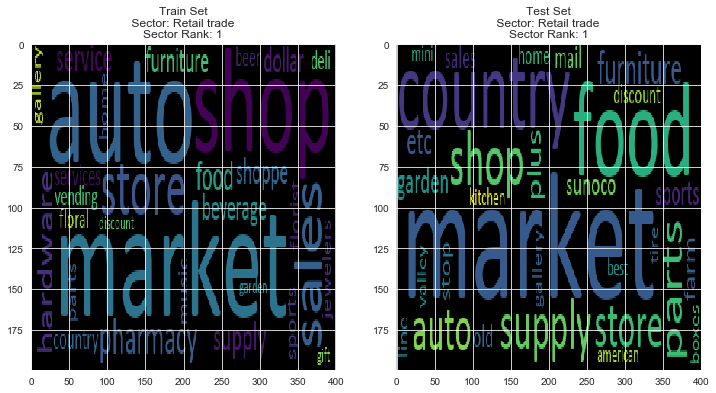

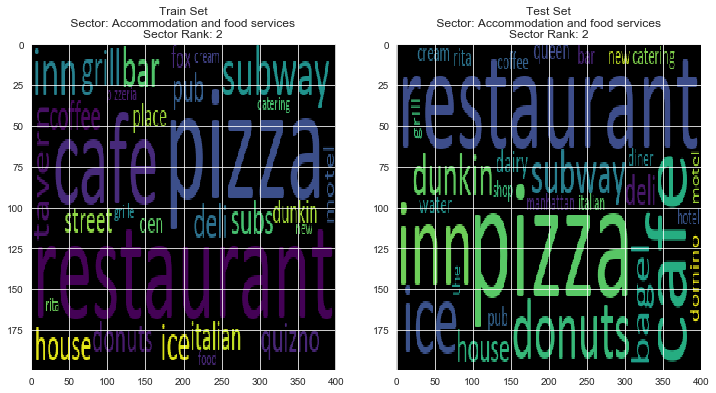

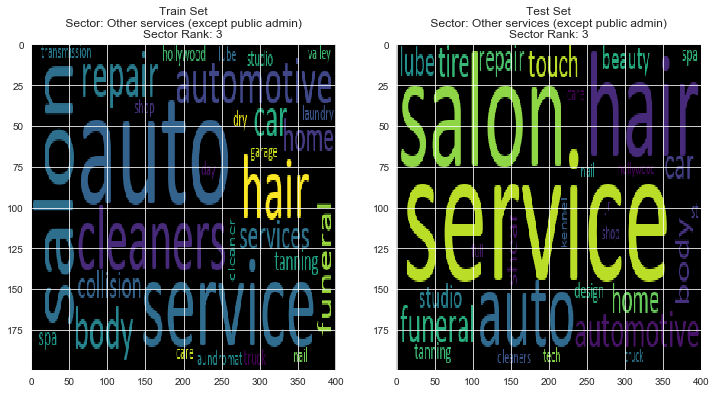

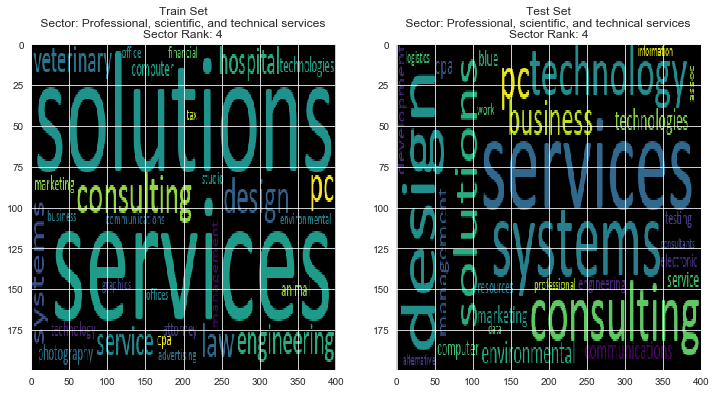

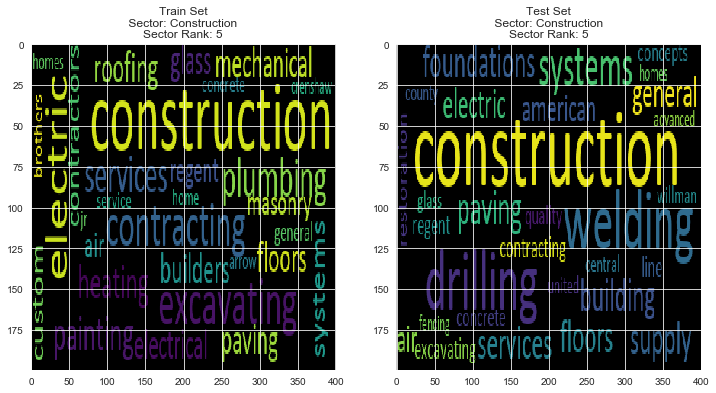

In [60]:
# Generating word cloud 
# make sure the path for the font is correct
for sector in top5sectors:
    # declare 1 x 2 plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # train set
    texttrain = trainmat.loc[sector, :] 
    wc1 = WordCloud(font_path='C:/Windows/Fonts/Calibri.ttf', \
                          background_color='black',max_words=30, relative_scaling=.5\
                         ).generate_from_frequencies(texttrain)
    
    ax1.imshow(wc1, aspect="auto")
    #ax1.savefig('wc{}train.png'.format(sector))
    ax1.set_title("Train Set\n Sector: {} \nSector Rank: {}".format(newdict[sector], 
                                                                   top5sectors.index(sector)+1))
    
    #test set
    texttest = testmat.loc[sector, :] 
    wc2 = WordCloud(font_path='C:/Windows/Fonts/Calibri.ttf', \
                          background_color='black',max_words=30, relative_scaling=.5\
                         ).generate_from_frequencies(texttest)
    
    ax2.imshow(wc2, aspect="auto")
    #ax1.savefig('wc{}train.png'.format(sector))
    ax2.set_title("Test Set\n Sector: {} \nSector Rank: {}".format(newdict[sector], 
                                                                   top5sectors.index(sector)+1))
    
    plt.show()


<div class="alert alert-block alert-info">
<b>
<li>in general, a lot of the same words show up frequently in both train and train sets, lending support to the results of the modelling which show a 71.7% chance of at least two similar predictions across 3 models. 
<li>bearing error rate in mind, let's add the final industry classification 'ypredmode' to our main dataset.</b></div>

In [61]:
# map df index keysof null sector values to predicted industry classifications
sectordict = {}
for n,m in enumerate(df[df.sector.isnull()].index):
    sectordict.update({m : testdf.ypredmode[n]})


In [62]:
dft = pd.DataFrame.from_dict(sectordict, orient='index', columns=['sector2'])
dft.head()

,sector2
1001725002,81
1001785009,44
1001885004,44
1001905008,44
1001915000,44


In [63]:
df = df.join(dft, how='outer')

In [64]:
df.sector = np.where(df.sector.isnull(), df.sector2, df.sector)

In [65]:
df.drop('sector2', axis=1, inplace=True)

In [66]:
df.to_pickle('./sectorcleaned.pkl')